In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle

plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True)
pd.set_option("display.max_columns", None)

In [3]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, classification_report

# Read in Data

In [4]:
full_df = pd.read_pickle("full_clean_df.pkl")
full_df.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'chronic_med_condition',
       'child_under_6_months', 'health_worker', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
       'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'age_group', 'education',
       'household_adults', 'household_children', 'h1n1_vaccine',
       'seasonal_vaccine', 'health_insurance_0.0', 'health_insurance_1.0',
       'health_insurance_nan', 'doctor_recc_h1n1_0.0', 'doctor_recc_h1n1_1.0',
       'doctor_recc_h1n1_nan', 'doctor_recc_seasonal_0.0',
       'doctor_recc_seasonal_1.0', 'doctor_recc_seasonal_nan',
       'income_poverty_<= $75,000, Above Poverty', 'income_poverty_> $75,000',
       'income_poverty_

In [5]:
all_resp = full_df.shape[0]
all_resp

24280

### split the data

In [6]:
# remove the holdeout
full_df, ho_df = train_test_split(
    full_df,
    test_size=0.2,
    shuffle=True,
    random_state=100
)

In [71]:
important_features = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 
            'opinion_h1n1_sick_from_vacc','health_insurance_1.0', 'health_insurance_0.0', 'health_insurance_nan', 
            'doctor_recc_h1n1_1.0', 'doctor_recc_h1n1_nan', 'doctor_recc_seasonal_0.0',]

features_df = full_df.drop(labels=['h1n1_vaccine', 'seasonal_vaccine', 'respondent_id'], axis = 1)
h1n1_target = full_df['h1n1_vaccine']
seasonal_target = full_df['seasonal_vaccine']
combined_targets = full_df[['h1n1_vaccine', 'seasonal_vaccine']]

# set up the algorithms

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, ComplementNB, CategoricalNB

In [9]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

In [10]:
logistic_regression = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('estimator', LogisticRegression(penalty="l2", C=1))
])

knn = KNeighborsClassifier(n_neighbors=5)
rfc = RandomForestClassifier()
svc = SVC(probability=True)
gnb = GaussianNB()
comnb = ComplementNB()
catnb = CategoricalNB()

classifier_list = [(logistic_regression, 'Logistic'), (knn, 'Nearest Neighbor'), 
                   (rfc, 'Random Forest'), (svc, 'SVC'), (gnb, "Gaussian NB"), (comnb, "Compement NB"), (catnb, "Categorical NB")]

In [11]:
def plot_classifier_rocs(X_train, X_eval, y_train, y_eval, classifier_list):
    fig, ax = plt.subplots(
        len(classifier_list), 1, figsize=(9,len(classifier_list)*9)
    )

    for i, c_tup in enumerate(classifier_list):
        if len(classifier_list) == 1:
            ax_curr=ax
        else:
            ax_curr=ax[i]
        c = c_tup[0] 
        c.fit(X_train, y_train)
        preds = c.predict_proba(X_eval)
        plot_roc(
            y_eval, 
            preds[:, 1], 
            c_tup[1],
            ax=ax_curr
        )

# Plot ROC for H1N1

In [12]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    h1n1_target,
    test_size=0.25,
    shuffle=True,
    stratify=h1n1_target,
    random_state=100
)    

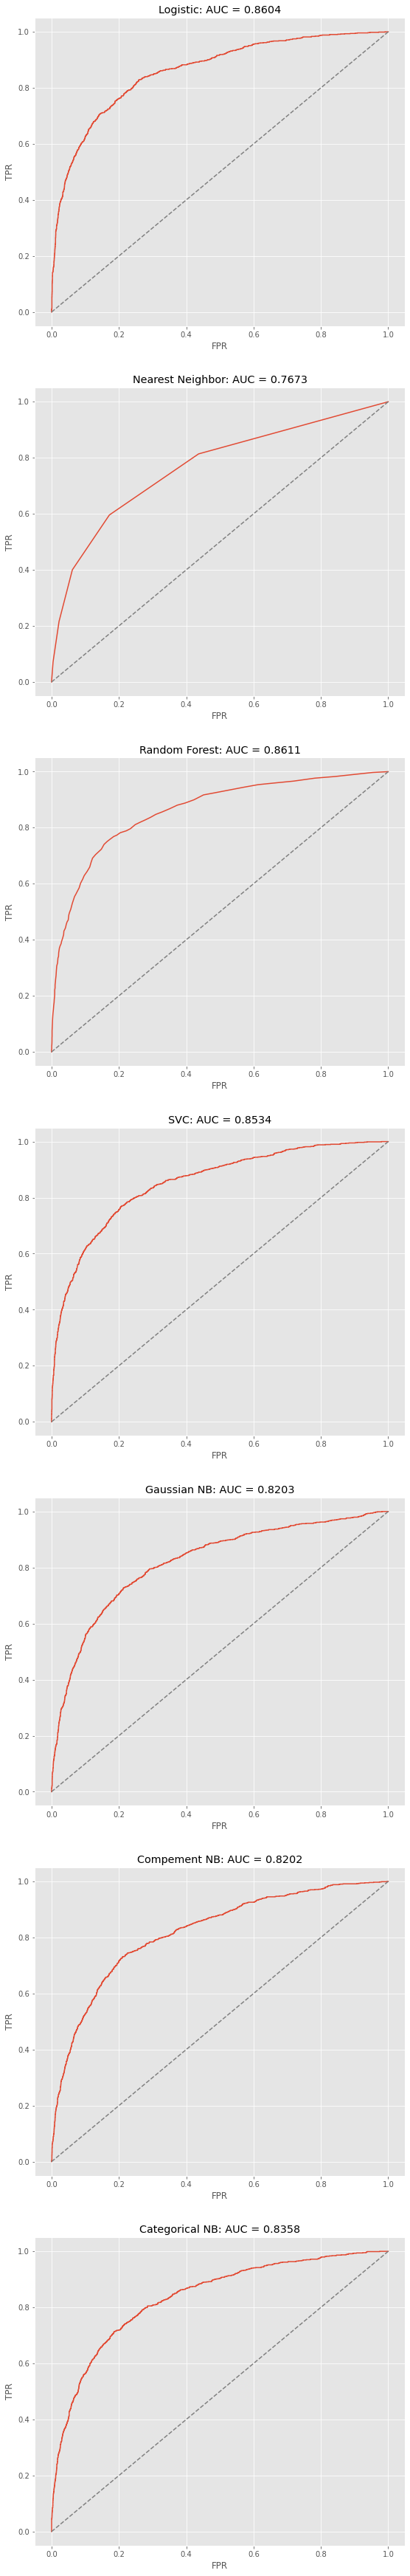

In [13]:
plot_classifier_rocs(X_train, X_eval, y_train, y_eval, classifier_list)

# Plot ROC for Seasonal

In [14]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    seasonal_target,
    test_size=0.25,
    shuffle=True,
    stratify=seasonal_target,
    random_state=100
)  

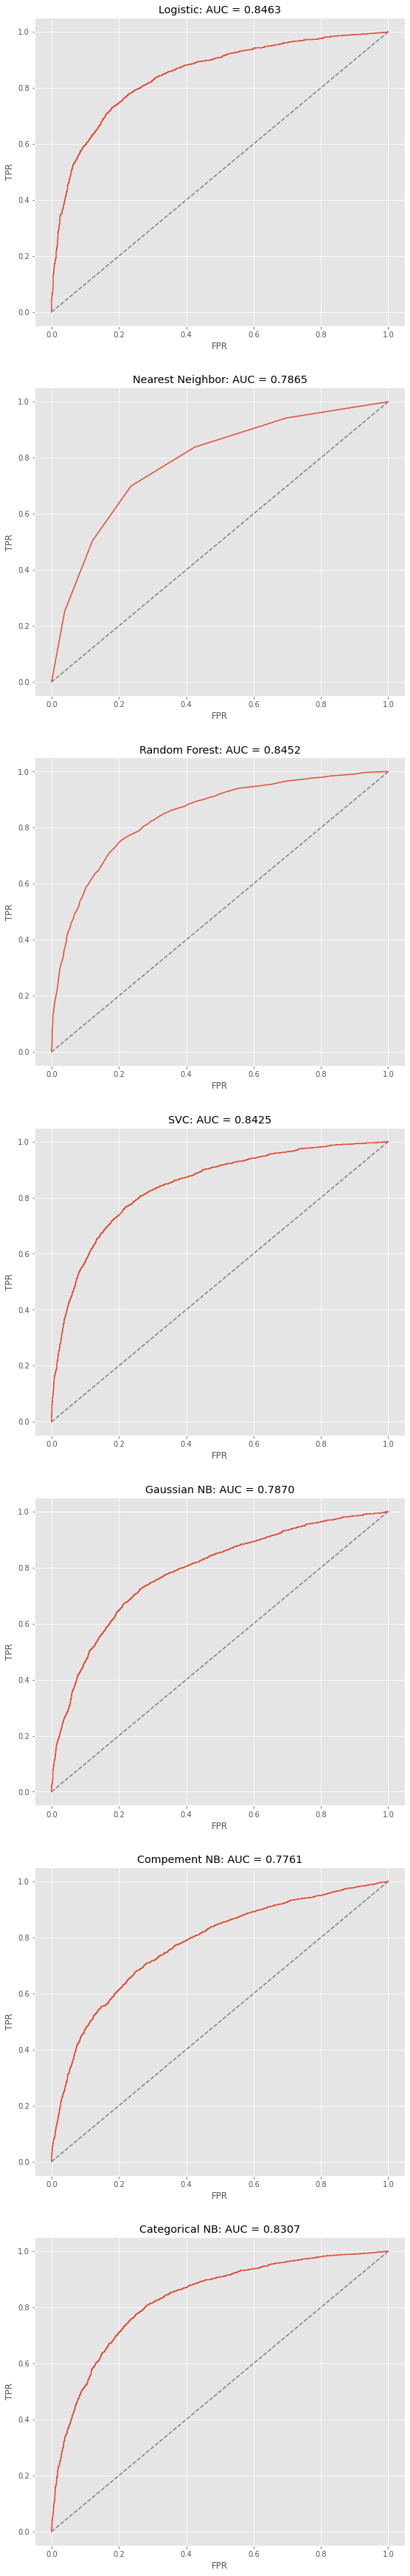

In [15]:
plot_classifier_rocs(X_train, X_eval, y_train, y_eval, classifier_list)

# Plot confusion for H1N1

In [16]:
def plot_confusion(y_true, y_score, label_name, ax):
    confusion = confusion_matrix(y_true, y_score)
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt='g',ax=ax,
               xticklabels=['No H1N1', 'Yes H1N1'],
               yticklabels=['No H1N1', 'Yes H1N1'])

    ax.set_ylabel('Predicted Visits')
    ax.set_xlabel('Actual Visits')
    ax.set_title(label_name);

In [17]:
def plot_classifier_confusions(X_train, X_eval, y_train, y_eval, classifier_list):
    fig, ax = plt.subplots(
            len(classifier_list), 1, figsize=(9,len(classifier_list)*9),
            dpi=100
        )

    for i, c_tup in enumerate(classifier_list):
        if len(classifier_list) == 1:
            ax_new=ax
        else:
            ax_new=ax[i]
            
        c = c_tup[0]
        c.fit(X_train, y_train)
        predict = c.predict(X_eval)
        plot_confusion(y_eval, predict, c_tup[1], ax_new);

In [18]:
classifier_list = [(logistic_regression, 'Logistic'), (rfc, 'Random Forest'), (svc, 'SVC'),(comnb, "Compement NB"), (catnb, "Categorical NB")]

In [19]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    h1n1_target,
    test_size=0.25,
    shuffle=True,
    stratify=h1n1_target,
    random_state=100
) 

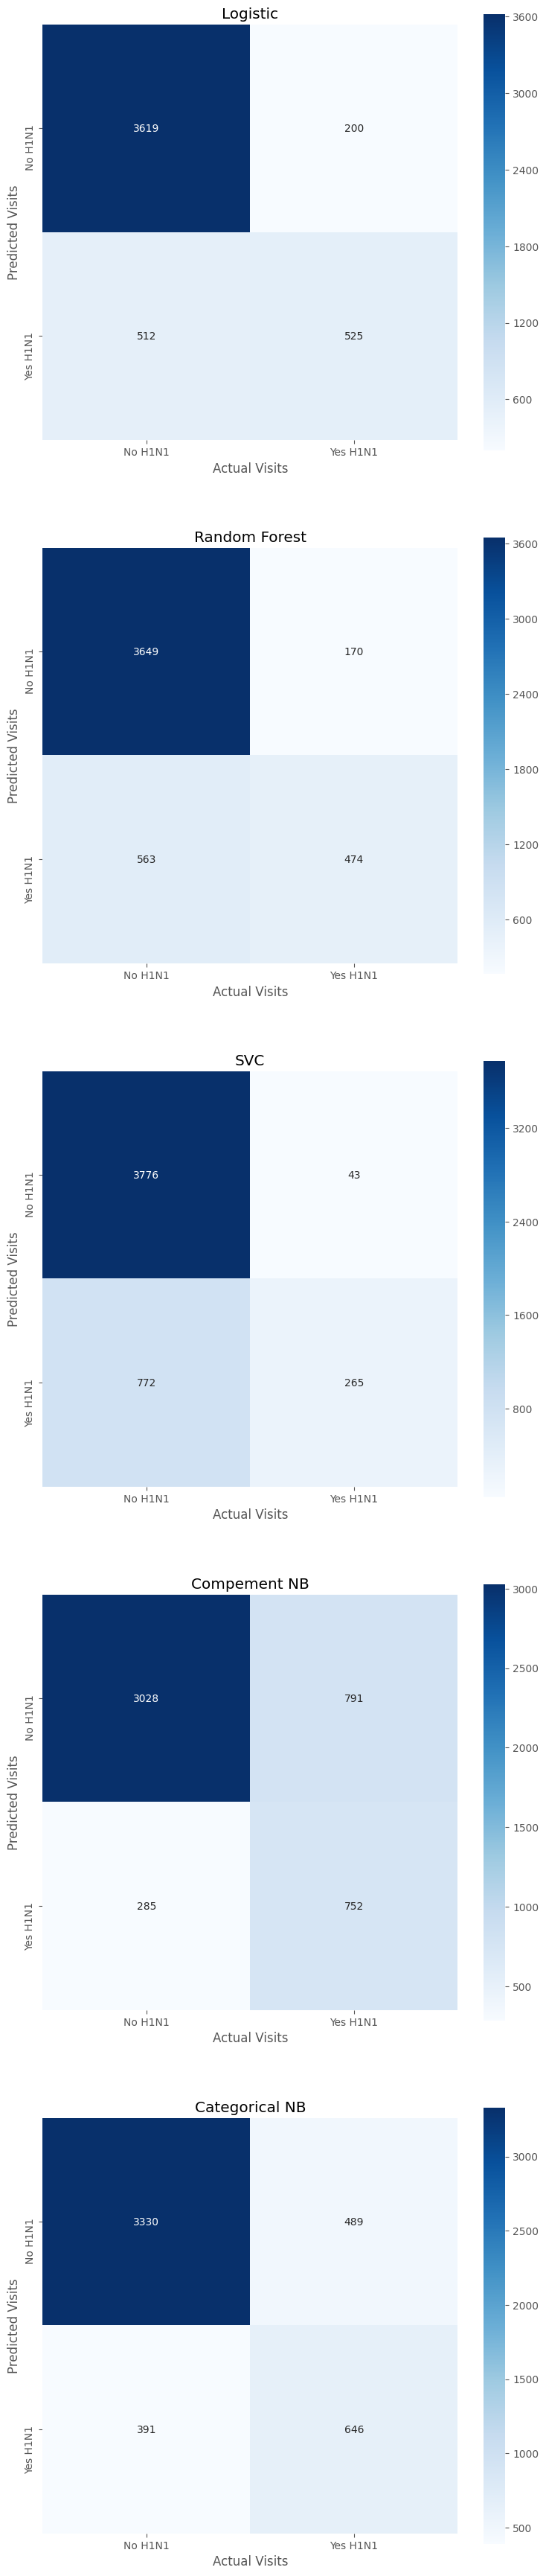

In [20]:
plot_classifier_confusions(X_train, X_eval, y_train, y_eval, classifier_list);

# Plot confusion for Seasonal

In [21]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    seasonal_target,
    test_size=0.25,
    shuffle=True,
    stratify=seasonal_target,
    random_state=100
) 

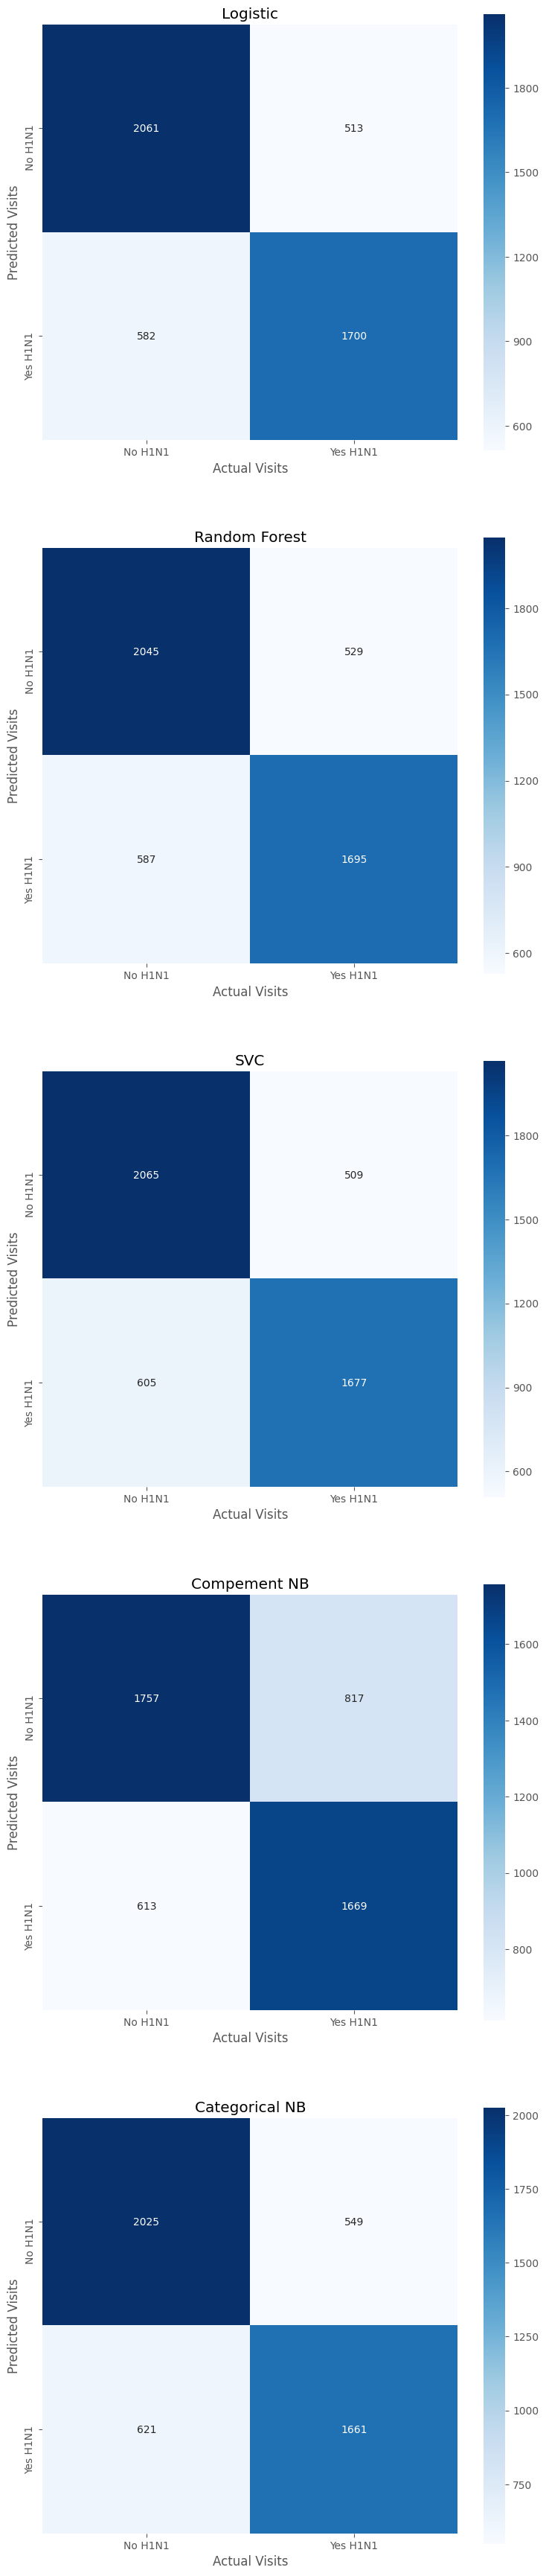

In [22]:
plot_classifier_confusions(X_train, X_eval, y_train, y_eval, classifier_list);

# Plot Scores H1N1

In [23]:
classifier_list = [(logistic_regression, 'Logistic'), (rfc, 'Random Forest'), (svc, 'SVC'),(comnb, "Compement NB"), (catnb, "Categorical NB")]

In [24]:
def plot_scores(X_train, y_train, X_eval, y_eval, classifier_list):
    for c_tup in classifier_list:
        c = c_tup[0]
        c.fit(X_train, y_train)
        print(c_tup[1])
        print(classification_report(y_eval, c.predict(X_eval), target_names=["No H1N1", "Yes H1N1"]))
        print("\n \n")

In [25]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    h1n1_target,
    test_size=0.25,
    shuffle=True,
    stratify=h1n1_target,
    random_state=100
) 

In [26]:
plot_scores(X_train, y_train, X_eval, y_eval, classifier_list)

Logistic
              precision    recall  f1-score   support

     No H1N1       0.88      0.95      0.91      3819
    Yes H1N1       0.72      0.51      0.60      1037

    accuracy                           0.85      4856
   macro avg       0.80      0.73      0.75      4856
weighted avg       0.84      0.85      0.84      4856


 

Random Forest
              precision    recall  f1-score   support

     No H1N1       0.87      0.95      0.91      3819
    Yes H1N1       0.73      0.46      0.56      1037

    accuracy                           0.85      4856
   macro avg       0.80      0.71      0.74      4856
weighted avg       0.84      0.85      0.83      4856


 

SVC
              precision    recall  f1-score   support

     No H1N1       0.83      0.99      0.90      3819
    Yes H1N1       0.86      0.26      0.39      1037

    accuracy                           0.83      4856
   macro avg       0.85      0.62      0.65      4856
weighted avg       0.84      0.83      

# Plot Scores Seasonal

In [27]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    seasonal_target,
    test_size=0.25,
    shuffle=True,
    stratify=seasonal_target,
    random_state=100
) 

In [28]:
plot_scores(X_train, y_train, X_eval, y_eval, classifier_list)

Logistic
              precision    recall  f1-score   support

     No H1N1       0.78      0.80      0.79      2574
    Yes H1N1       0.77      0.74      0.76      2282

    accuracy                           0.77      4856
   macro avg       0.77      0.77      0.77      4856
weighted avg       0.77      0.77      0.77      4856


 

Random Forest
              precision    recall  f1-score   support

     No H1N1       0.78      0.80      0.79      2574
    Yes H1N1       0.76      0.74      0.75      2282

    accuracy                           0.77      4856
   macro avg       0.77      0.77      0.77      4856
weighted avg       0.77      0.77      0.77      4856


 

SVC
              precision    recall  f1-score   support

     No H1N1       0.77      0.80      0.79      2574
    Yes H1N1       0.77      0.73      0.75      2282

    accuracy                           0.77      4856
   macro avg       0.77      0.77      0.77      4856
weighted avg       0.77      0.77      

# Feature Importance for H1N1

In [29]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    h1n1_target,
    test_size=0.25,
    shuffle=True,
    stratify=h1n1_target,
    random_state=100
) 

In [30]:
rfc.fit(X_train, y_train);
rfc.feature_importances_
features_df.columns;

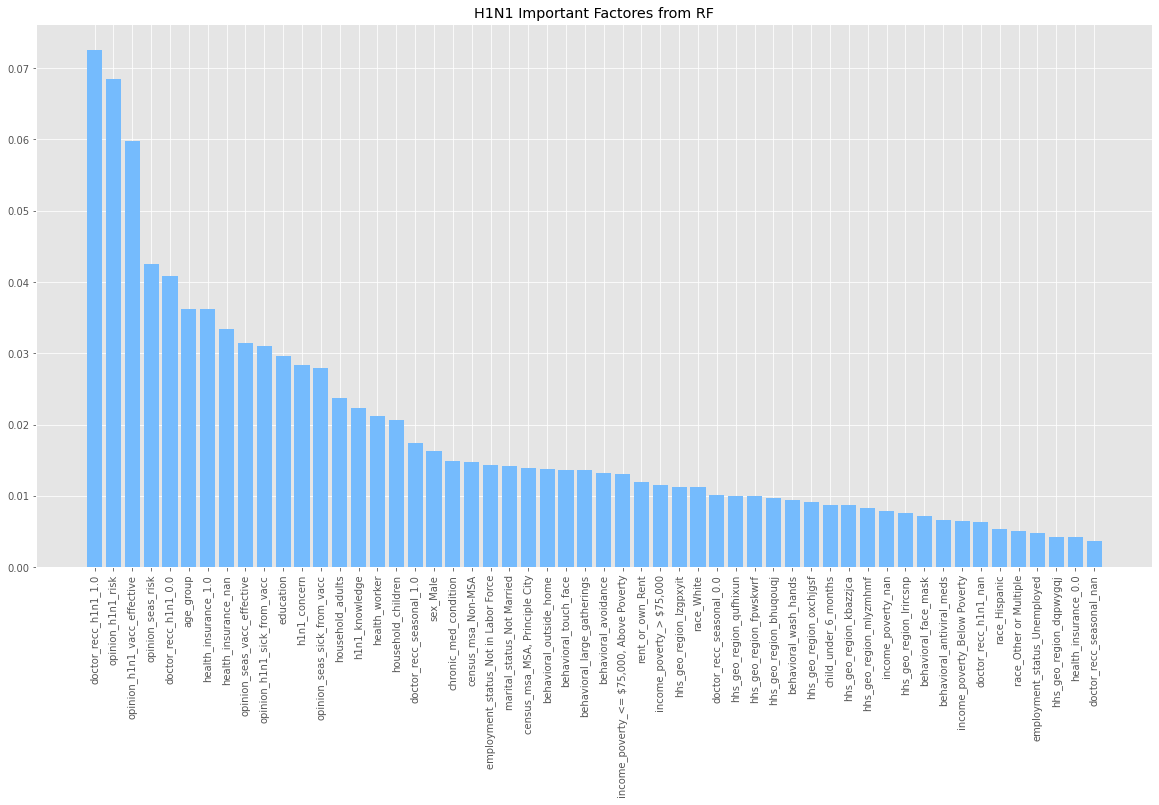

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plt.title('H1N1 Important Factores from RF')
for c in sorted(zip(rfc.feature_importances_, features_df.columns), reverse=True):
    plt.bar(c[1], c[0], color='xkcd:sky blue')
    plt.xticks(rotation='vertical')

In [32]:
logistic_regression.fit(X_train, y_train)
classifier = logistic_regression.named_steps['estimator']
classifier.coef_

array([[ 0.01079177,  0.11083667, -0.01031199, -0.04478743,  0.01693743,
         0.00510276, -0.07577829,  0.00836858,  0.02356923,  0.07982385,
         0.0748837 ,  0.30271689,  0.58955578,  0.55630388,  0.01961579,
         0.1409761 ,  0.1627513 , -0.10829289,  0.1245314 ,  0.10836515,
        -0.02964917, -0.04243124, -0.00967184,  0.41735118, -0.41624609,
        -0.37644919,  0.49168409, -0.11336595,  0.16546099, -0.10988254,
        -0.11336595, -0.02543619,  0.01090462,  0.0002305 ,  0.02397438,
         0.09303025,  0.09693502,  0.12710801,  0.08133328, -0.07743252,
         0.00254766,  0.06145455,  0.00086149, -0.05180852, -0.11633065,
        -0.0556972 , -0.03428556, -0.00533519, -0.08336836, -0.0082454 ,
         0.00176696, -0.01647041,  0.03057672,  0.05311289]])

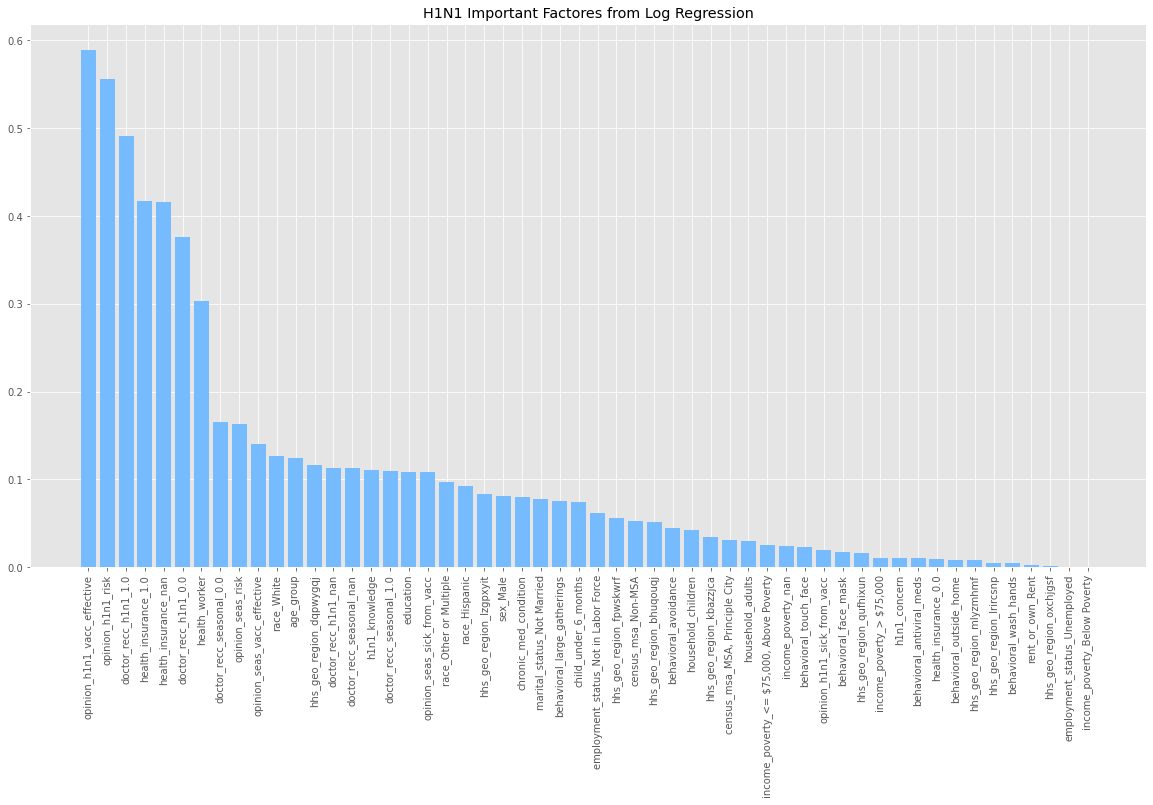

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plt.title('H1N1 Important Factores from Log Regression')
for c in sorted(zip(abs(classifier.coef_[0]), features_df.columns), reverse=True):
    plt.bar(c[1], c[0], color='xkcd:sky blue')
    plt.xticks(rotation='vertical')

In [34]:
top_rf = sorted(zip(rfc.feature_importances_, features_df.columns), reverse=True)[:15]
top_rf_cats = [x[1] for  x in top_rf]
top_rf_cats;

In [35]:
top_log = sorted(zip(abs(classifier.coef_[0]), features_df.columns), reverse=True)[:15]
top_log_cats = [x[1] for  x in top_log]
top_log_cats;

In [36]:
combined = [x for x in top_rf_cats if x in top_log_cats]
combined

['doctor_recc_h1n1_1.0',
 'opinion_h1n1_risk',
 'opinion_h1n1_vacc_effective',
 'opinion_seas_risk',
 'doctor_recc_h1n1_0.0',
 'age_group',
 'health_insurance_1.0',
 'health_insurance_nan',
 'opinion_seas_vacc_effective']

# Feature Importance for Seasonal

In [37]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    seasonal_target,
    test_size=0.25,
    shuffle=True,
    stratify=seasonal_target,
    random_state=100
) 

In [38]:
rfc.fit(X_train, y_train);
rfc.feature_importances_

array([0.0294138 , 0.0229586 , 0.00524435, 0.01251221, 0.00578214,
       0.00976533, 0.01323372, 0.0134329 , 0.0141885 , 0.01585332,
       0.00698867, 0.01587972, 0.03491686, 0.0371567 , 0.02856379,
       0.08986615, 0.09301657, 0.03122144, 0.06487073, 0.03029118,
       0.02447753, 0.02165093, 0.00734589, 0.01505542, 0.01091764,
       0.00891085, 0.01450098, 0.00516963, 0.02604203, 0.05078334,
       0.00512425, 0.0129222 , 0.01179726, 0.00726491, 0.00781132,
       0.00533637, 0.00514761, 0.01149436, 0.01607034, 0.01432875,
       0.01301158, 0.01515583, 0.00574845, 0.00999321, 0.00470023,
       0.00963806, 0.00944549, 0.00843727, 0.01069913, 0.00781443,
       0.00971654, 0.00997007, 0.01457511, 0.0137863 ])

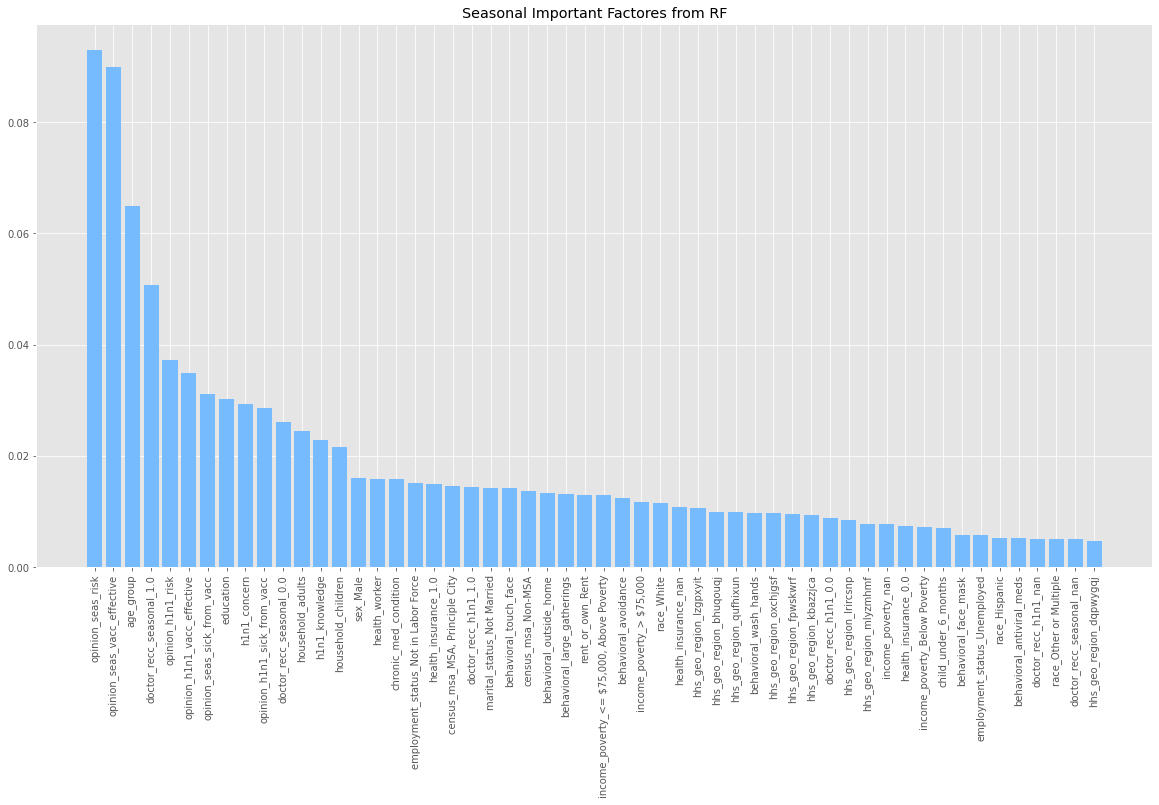

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plt.title('Seasonal Important Factores from RF')
for c in sorted(zip(rfc.feature_importances_, features_df.columns), reverse=True):
    plt.bar(c[1], c[0], color='xkcd:sky blue')
    plt.xticks(rotation='vertical')

In [40]:
logistic_regression.fit(X_train, y_train)
classifier = logistic_regression.named_steps['estimator']

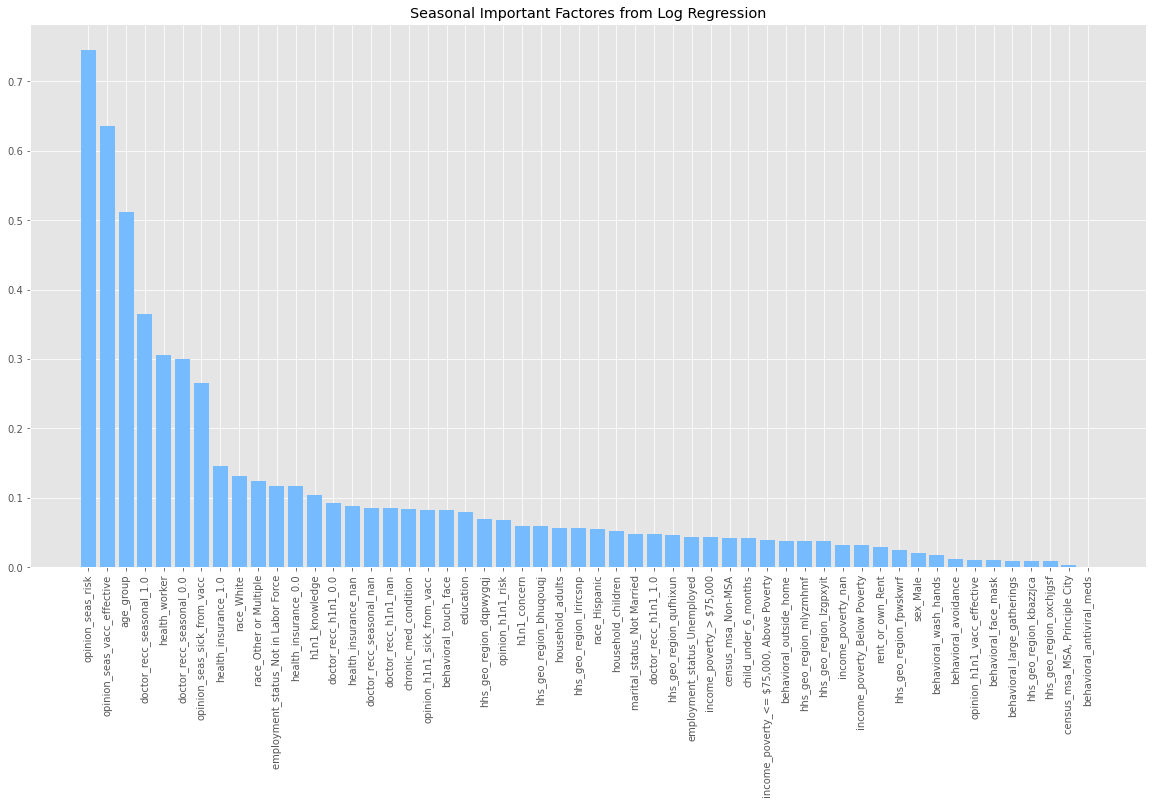

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plt.title('Seasonal Important Factores from Log Regression')
for c in sorted(zip(abs(classifier.coef_[0]), features_df.columns), reverse=True):
    plt.bar(c[1], c[0], color='xkcd:sky blue')
    plt.xticks(rotation='vertical')

In [42]:
top_rf = sorted(zip(rfc.feature_importances_, features_df.columns), reverse=True)[:15]
top_rf_cats = [x[1] for  x in top_rf]
top_rf_cats;

In [43]:
top_log = sorted(zip(abs(classifier.coef_[0]), features_df.columns), reverse=True)[:15]
top_log_cats = [x[1] for  x in top_log]
top_log_cats;

In [44]:
combined = [x for x in top_rf_cats if x in top_log_cats]
combined

['opinion_seas_risk',
 'opinion_seas_vacc_effective',
 'age_group',
 'doctor_recc_seasonal_1.0',
 'opinion_seas_sick_from_vacc',
 'doctor_recc_seasonal_0.0',
 'h1n1_knowledge']

# Over Sample
For our inbalanced h1n1

In [45]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [46]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    h1n1_target,
    test_size=0.25,
    shuffle=True,
    stratify=h1n1_target,
    random_state=100
) 

In [47]:
len(X_train)

14568

In [48]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

In [49]:
len(X_smoted)

22912

In [50]:
y_smoted

0        0
1        0
2        0
3        0
4        0
        ..
22907    1
22908    1
22909    1
22910    1
22911    1
Name: h1n1_vaccine, Length: 22912, dtype: int64

In [51]:
sum(y_smoted)/len(y_smoted)

0.5

In [52]:
classifier_list = [(logistic_regression, 'Logistic'), (knn, 'Nearest Neighbor'), 
                   (rfc, 'Random Forest'), (svc, 'SVC'), (gnb, "Gaussian")]

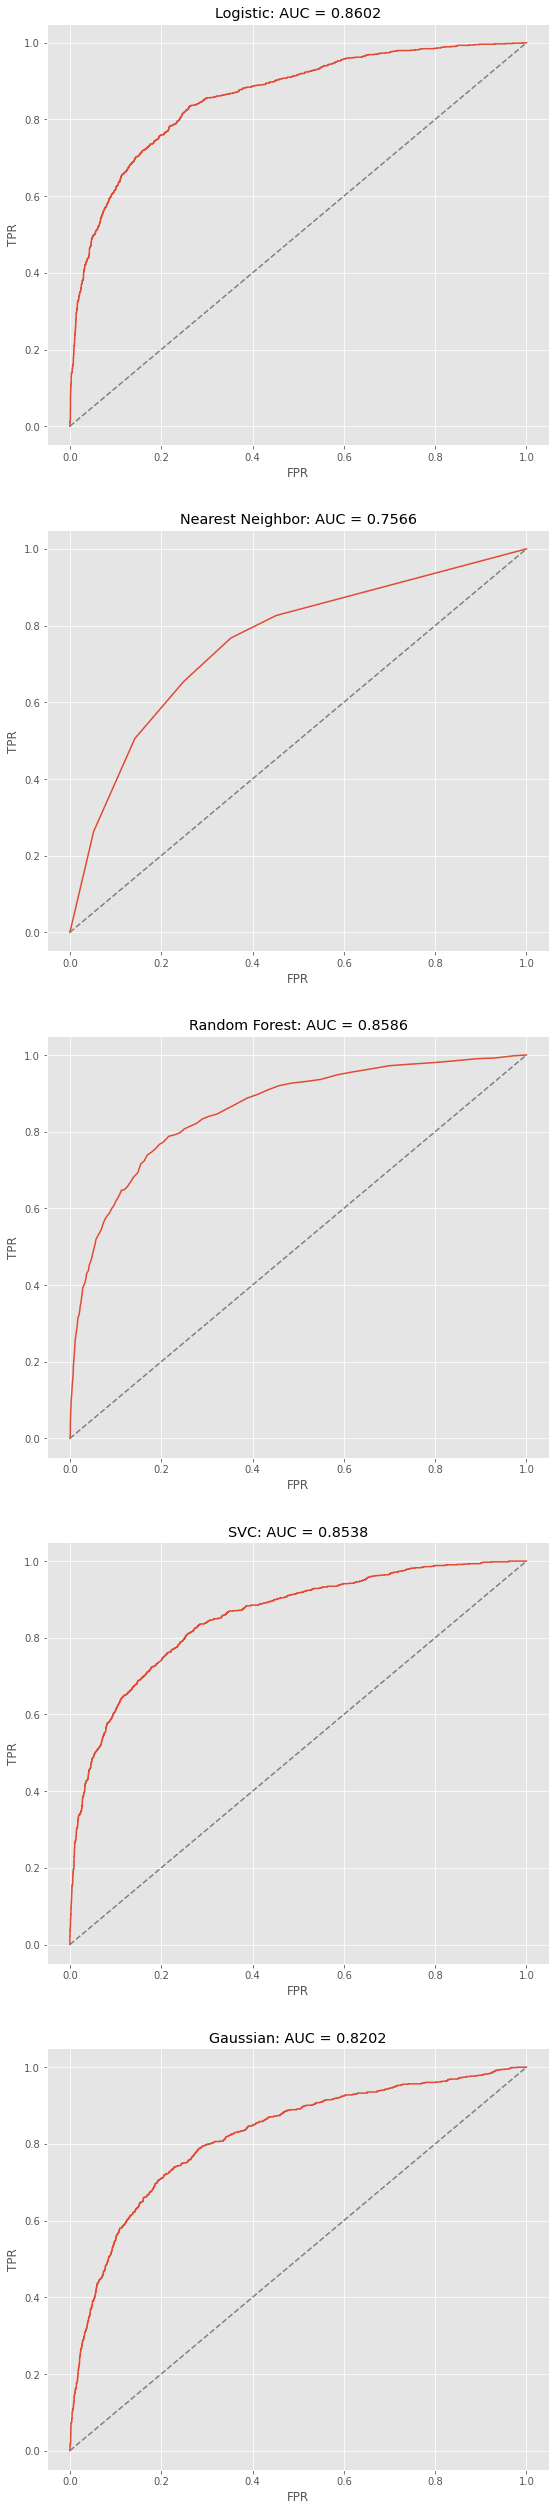

In [53]:
plot_classifier_rocs(X_resampled, X_eval, y_resampled, y_eval, classifier_list)

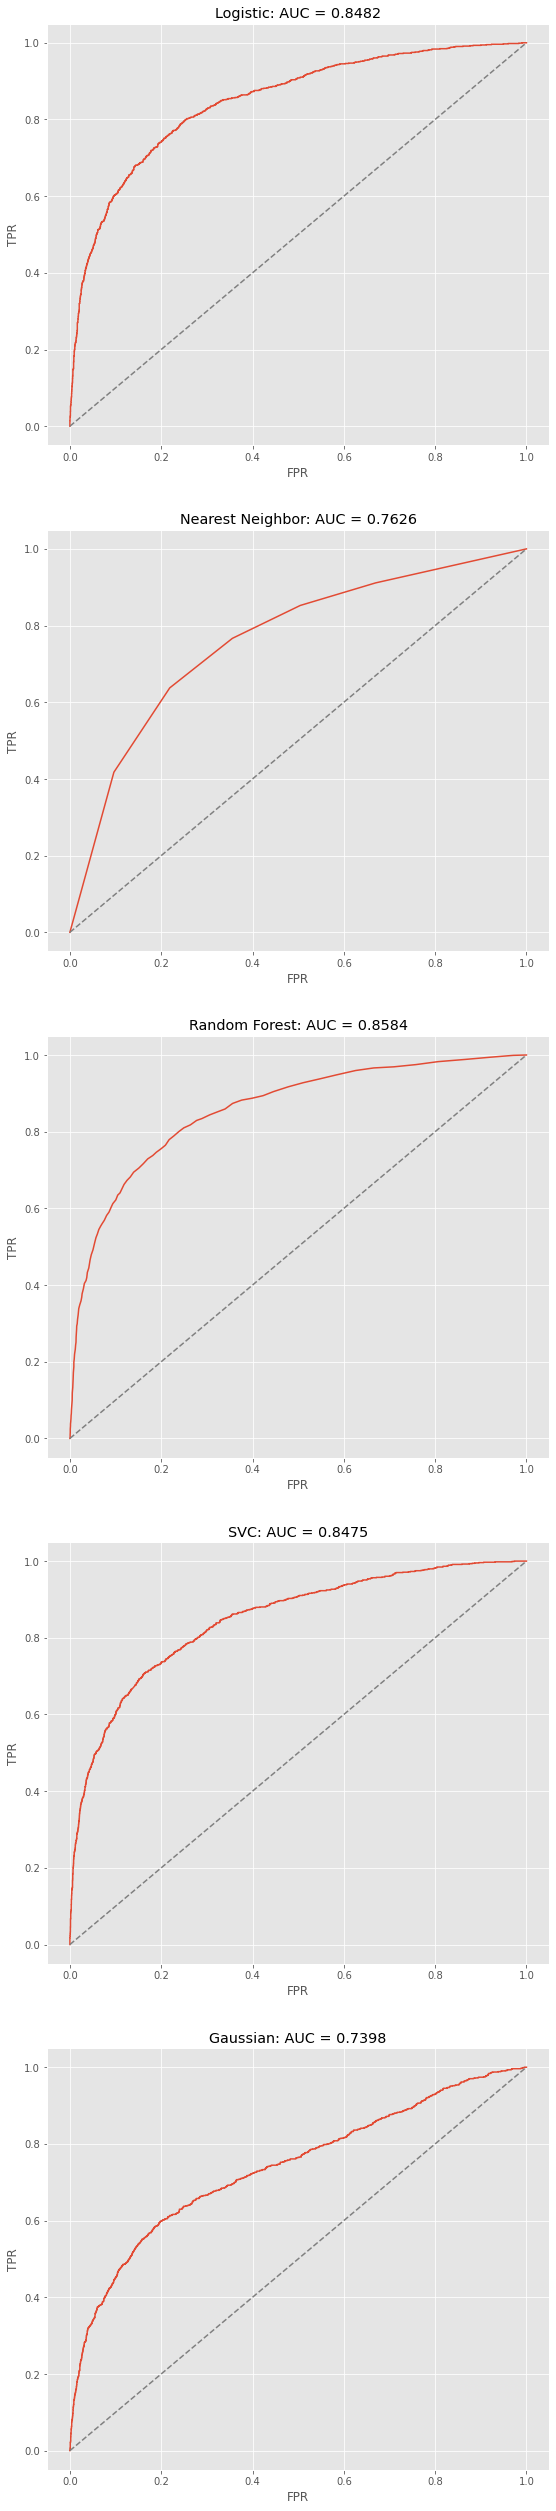

In [54]:
plot_classifier_rocs(X_smoted, X_eval, y_smoted, y_eval, classifier_list)

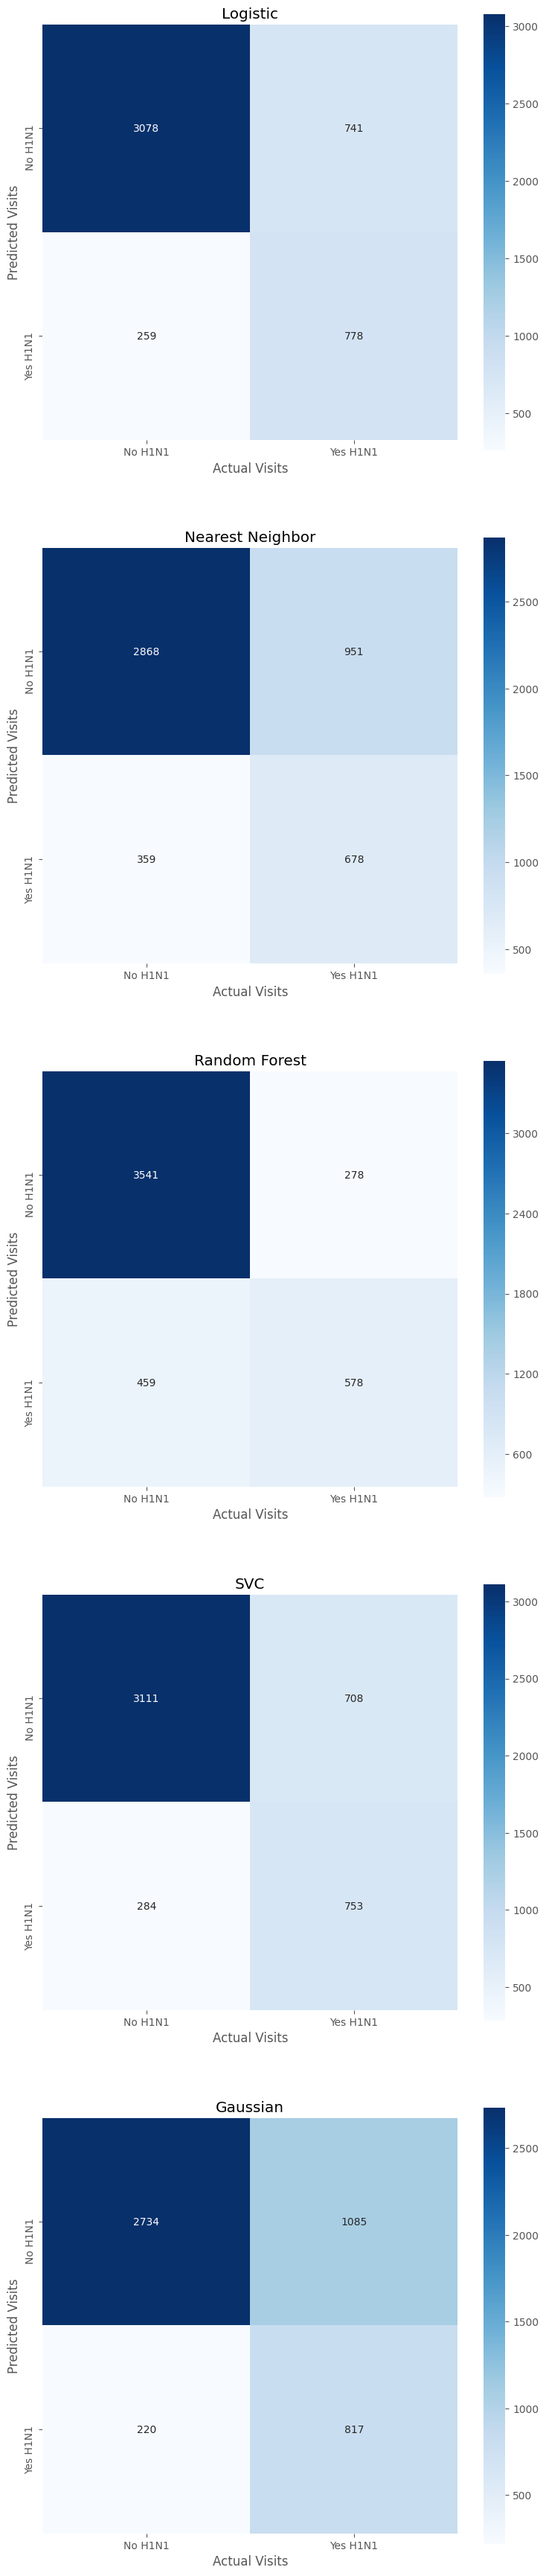

In [55]:
plot_classifier_confusions(X_resampled, X_eval, y_resampled, y_eval, classifier_list)

# Ensemble H1N1

In [56]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier

In [57]:
classifier_list = [('Logistic', logistic_regression), ('Random Forest', rfc), ('SVC', svc)]

In [58]:
voting_model = VotingClassifier(estimators=classifier_list,
                                    voting='soft', #<-- sklearn calls this soft voting
                                    n_jobs=-1)

In [59]:
voting_model.fit(X_resampled, y_resampled)

VotingClassifier(estimators=[('Logistic',
                              Pipeline(steps=[('standard_scaler',
                                               StandardScaler()),
                                              ('estimator',
                                               LogisticRegression(C=1))])),
                             ('Random Forest', RandomForestClassifier()),
                             ('SVC', SVC(probability=True))],
                 n_jobs=-1, voting='soft')

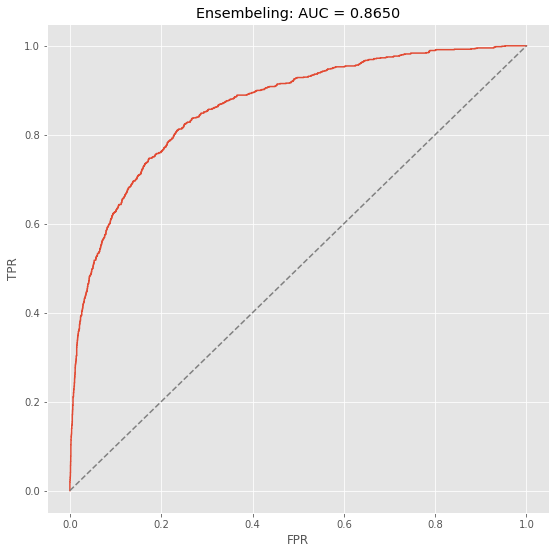

In [60]:
plot_classifier_rocs(X_resampled, X_eval, y_resampled, y_eval, [(voting_model, 'Ensembeling')])

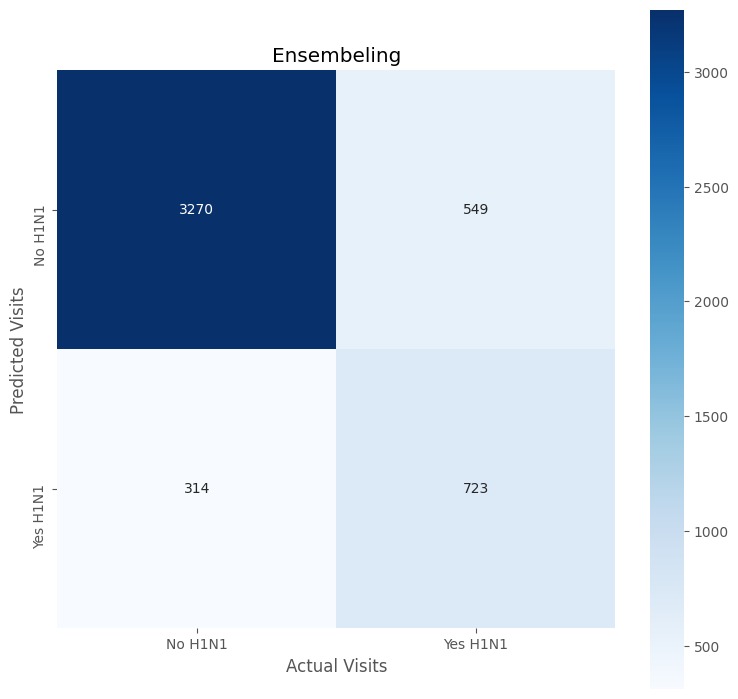

In [61]:
plot_classifier_confusions(X_resampled, X_eval, y_resampled, y_eval, [(voting_model, 'Ensembeling')])

In [62]:
voting_model_hard = VotingClassifier(estimators=classifier_list,
                                    voting='hard', #<-- sklearn calls this soft voting
                                    n_jobs=-1)

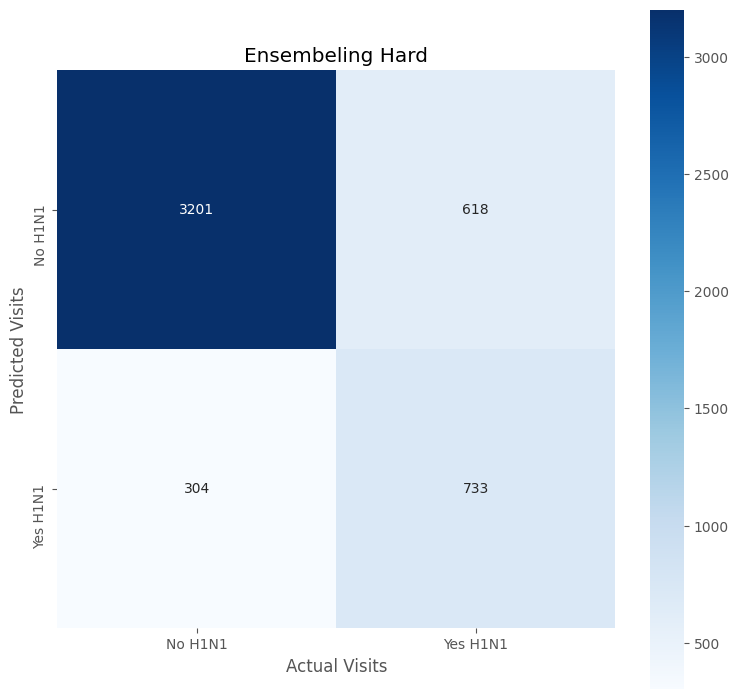

In [63]:
plot_classifier_confusions(X_resampled, X_eval, y_resampled, y_eval, [(voting_model_hard, 'Ensembeling Hard')])

# Best model is RF with over sampling

In [64]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    seasonal_target,
    test_size=0.25,
    shuffle=True,
    stratify=seasonal_target,
    random_state=100
) 

In [65]:
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

In [66]:
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [67]:
print(classification_report(y_eval, rfc.predict(X_eval), target_names=["No H1N1", "Yes H1N1"]))

              precision    recall  f1-score   support

     No H1N1       0.78      0.80      0.79      2574
    Yes H1N1       0.77      0.75      0.76      2282

    accuracy                           0.78      4856
   macro avg       0.78      0.77      0.77      4856
weighted avg       0.78      0.78      0.78      4856



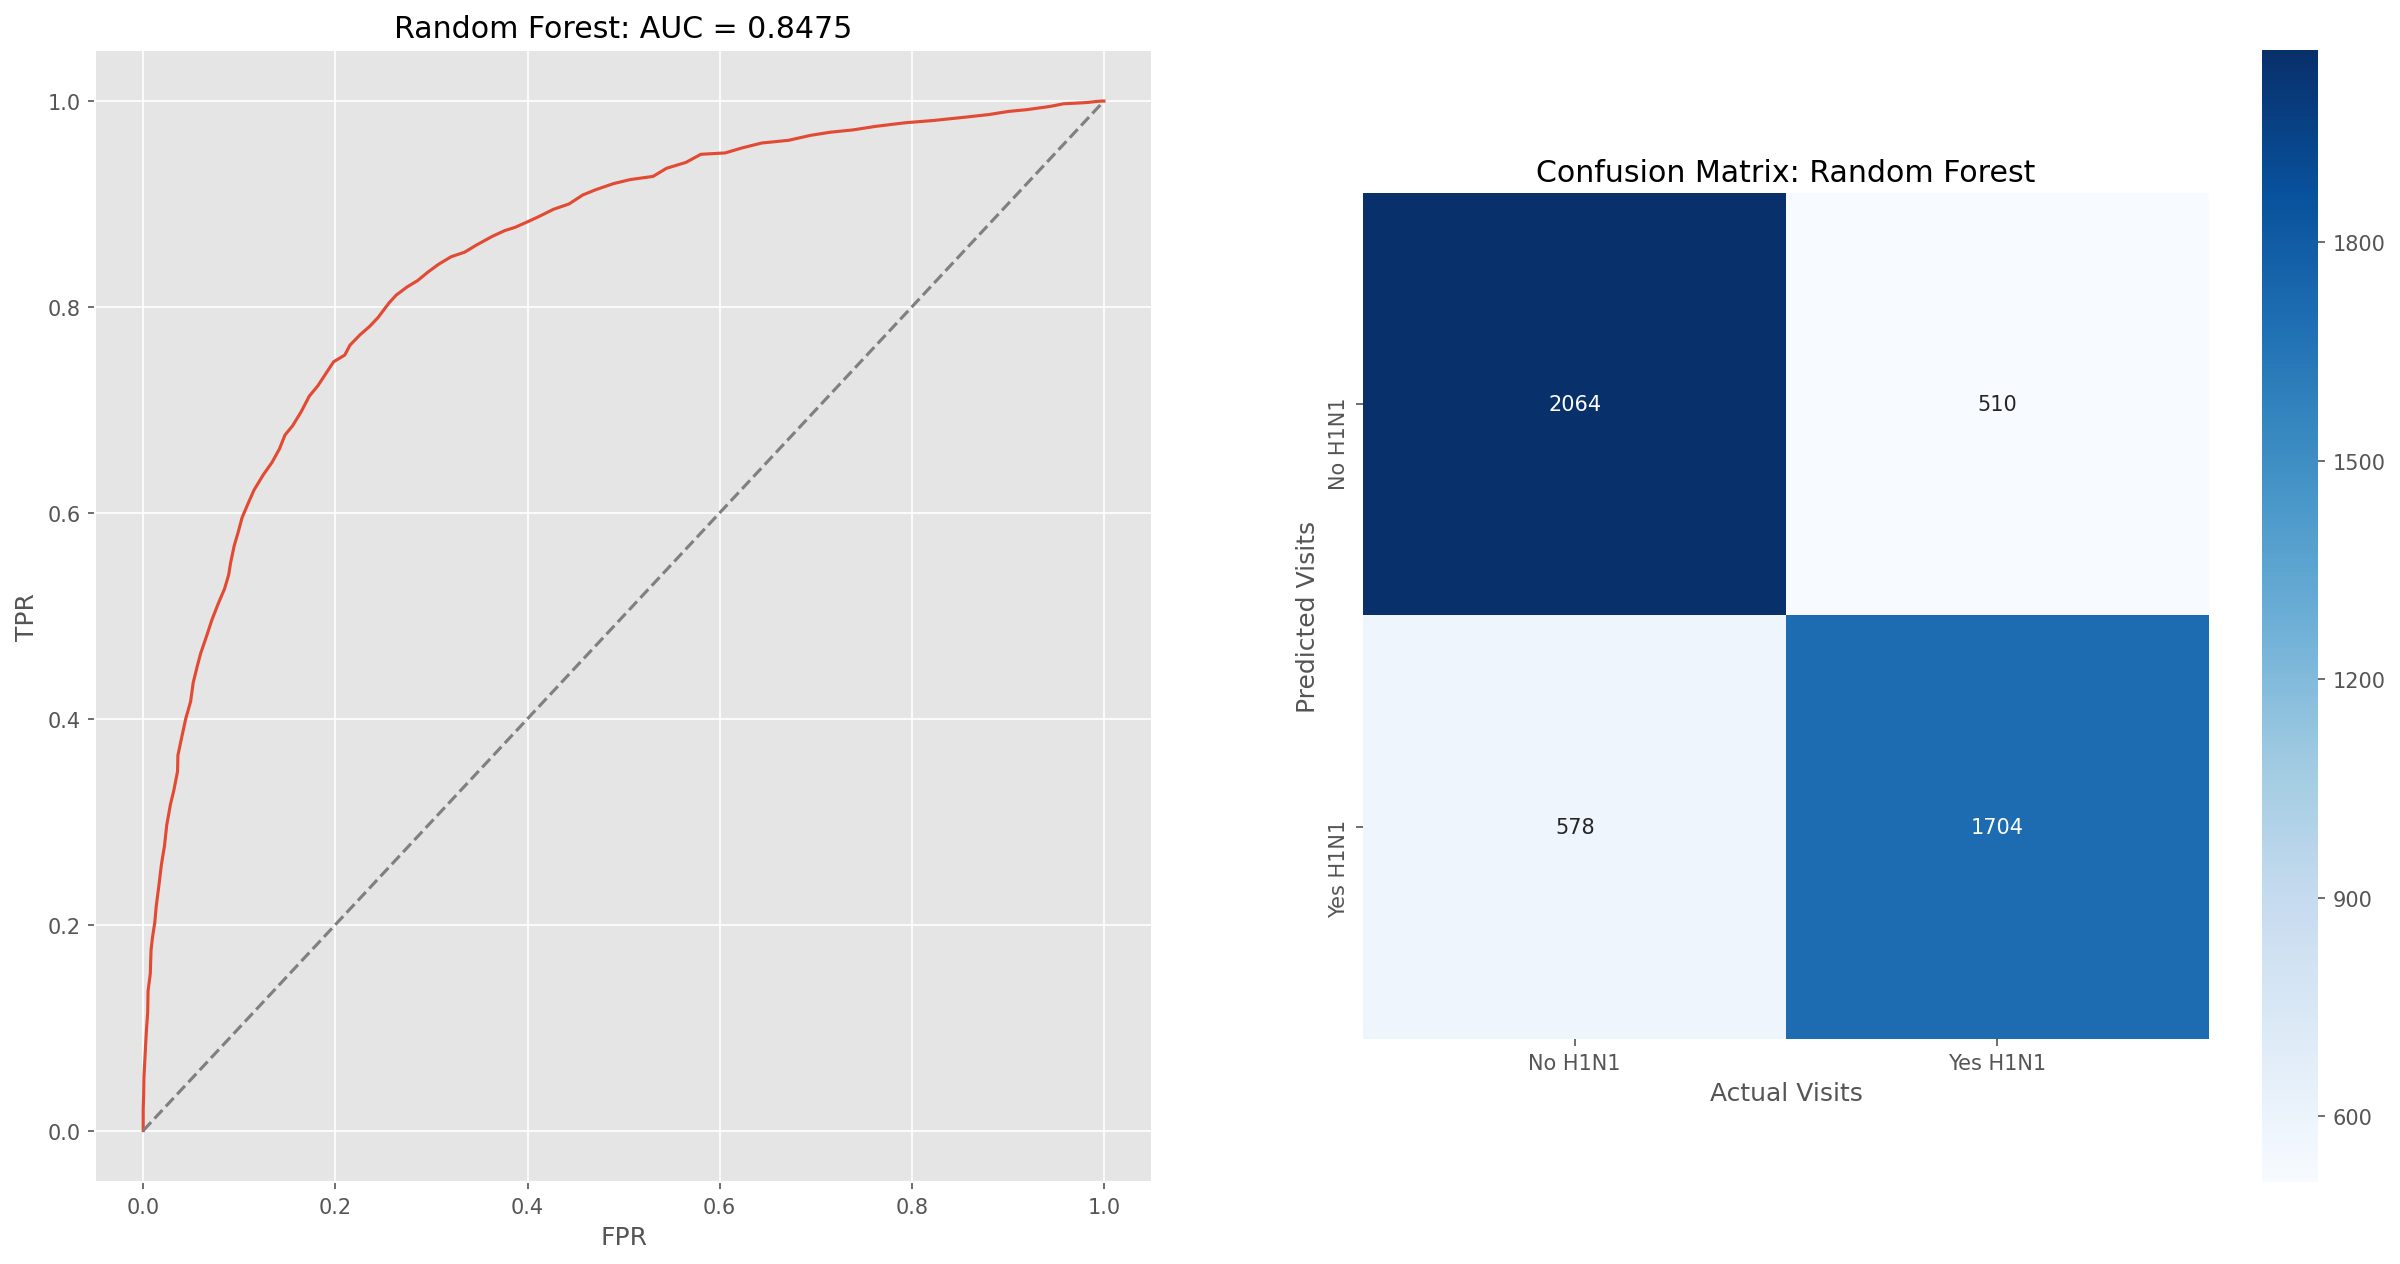

In [68]:
fig, ax = plt.subplots(
        1, 2, figsize=(20,10), dpi=150
    )
plot_roc(y_eval, rfc.predict_proba(X_eval)[:,1], "Random Forest", ax[0])

confusion = confusion_matrix(y_eval, rfc.predict(X_eval))
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt='g',ax=ax[1],
           xticklabels=['No H1N1', 'Yes H1N1'],
           yticklabels=['No H1N1', 'Yes H1N1'])

ax[1].set_ylabel('Predicted Visits')
ax[1].set_xlabel('Actual Visits')
ax[1].set_title("Confusion Matrix: Random Forest")
plt.savefig('random_forrest_seasonal.png');

# combine models into one

In [69]:
from sklearn.multioutput import MultiOutputClassifier

In [73]:
combined_model = MultiOutputClassifier(
    estimator=RandomForestClassifier()
)

In [74]:
combined_model.fit(features_df, combined_targets)


MultiOutputClassifier(estimator=RandomForestClassifier())

In [75]:
preds = combined_model.predict_proba(features_df)

In [77]:
len(preds[0]), len(preds[1])

(19424, 19424)

In [79]:
filename = "combined_model.pkl"

In [82]:
pickle.dump(combined_model, open(filename, 'wb'))

In [83]:
loaded_model = pickle.load(open(filename, 'rb'))

In [84]:
loaded_model.predict_proba(features_df)

[array([[0.95, 0.05],
        [0.98, 0.02],
        [0.97, 0.03],
        ...,
        [0.98, 0.02],
        [0.26, 0.74],
        [0.87, 0.13]]), array([[0.05, 0.95],
        [0.13, 0.87],
        [0.94, 0.06],
        ...,
        [0.96, 0.04],
        [0.89, 0.11],
        [0.31, 0.69]])]

In [92]:
features_df.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'chronic_med_condition',
       'child_under_6_months', 'health_worker', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
       'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'age_group', 'education',
       'household_adults', 'household_children', 'health_insurance_0.0',
       'health_insurance_1.0', 'health_insurance_nan', 'doctor_recc_h1n1_0.0',
       'doctor_recc_h1n1_1.0', 'doctor_recc_h1n1_nan',
       'doctor_recc_seasonal_0.0', 'doctor_recc_seasonal_1.0',
       'doctor_recc_seasonal_nan', 'income_poverty_<= $75,000, Above Poverty',
       'income_poverty_> $75,000', 'income_poverty_Below Poverty',
       'income_poverty_nan', 'race_Hispanic', 'race

In [100]:
zeroes = [0]*54
preds = loaded_model.predict_proba([zeroes])

In [104]:
preds[0][0][1]

0.08